# From Neural Architecture Search to Automated Deep Ensemble with Uncertainty Quantification

In [ ]:
!pip install deephyper["autodeuq"]

## Imports and GPU Detection <a class="anchor" id="imports-and-gpu-detection"></a>

In [1]:
import json
import os
import pathlib
import shutil

!export TF_CPP_MIN_LOG_LEVEL=3
!export TF_XLA_FLAGS=--tf_xla_enable_xla_devices

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

<div class="alert alert-info">
    
<b>Note</b>
    
The `TF_CPP_MIN_LOG_LEVEL` can be used to avoid the logging of Tensorflow *DEBUG*, *INFO* and *WARNING* statements.
    
</div>

<div class="alert alert-info">
    
<b>Note</b>
    
The following can be used to detect if **GPU** devices are available on the current host.
    
</div>

In [2]:
available_gpus = tf.config.list_physical_devices("GPU")
n_gpus = len(available_gpus)
if n_gpus > 1:
    n_gpus -= 1
is_gpu_available = n_gpus > 0

if is_gpu_available:
    print(f"{n_gpus} GPU{'s are' if n_gpus > 1 else ' is'} available.")
else:
    print("No GPU available")

No GPU available


## Start Ray

We launch the Ray run-time depending on the detected local ressources. If GPU(s) is(are) detected then 1 worker is started for each GPU. If not, then only 1 worker is started. You can start more workers by setting `num_cpus=1` to a value greater than 1.

<div class="alert alert-warning">

<b>Warning</b>
    
In the case of GPUs it is important to follow this scheme to avoid multiple processes (Ray workers vs current process) to lock the same GPU.
    
</div>

In [3]:
import ray

if not(ray.is_initialized()):
    if is_gpu_available:
        ray.init(num_cpus=n_gpus, num_gpus=n_gpus, log_to_driver=False)            
    else:
        ray.init(num_cpus=4, log_to_driver=False)

## A Synthetic Dataset <a class="anchor" id="a-synthetic-dataset"></a>

Now, we will start by defining our artificial dataset based on a Sinus curve. We will first generate data for a **training set** (used for estimation) and a **testing set** (used to evaluate the final performance). Then the training set will be sub-divided in a new **training set** (used to estimate the neural network weights) and **validation set** (used to estimate the neural network hyperparameters and architecture). The data are generated from the following function:

$$ y = f(x) = 2 \cdot \sin(x) + \epsilon$$

The training data will be generated in a range between $[-30, -20]$ with $\epsilon \sim \mathcal{N}(0,0.25)$ and  in a range between $[20, 30]$ with $\epsilon \sim \mathcal{N}(0,1)$. The code for the training data is then corresponding to:

In [4]:
def load_data_train_test(random_state=42):
    rs = np.random.RandomState(random_state)

    train_size = 400 
    f = lambda x: 2*np.sin(x) # a simlpe affine function

    x_1 = rs.uniform(low=-30, high=-20.0, size=train_size//2)
    eps_1 = rs.normal(loc=0.0, scale=0.5, size=train_size//2)
    y_1 = f(x_1) + eps_1

    x_2 = rs.uniform(low=20.0, high=30.0, size=train_size//2)
    eps_2 = rs.normal(loc=0.0, scale=1.0, size=train_size//2)
    y_2 = f(x_2) + eps_2

    x = np.concatenate([x_1, x_2], axis=0)
    y = np.concatenate([y_1, y_2], axis=0)

    x_tst = np.linspace(-40.0, 40.0, 200)
    y_tst = f(x_tst)

    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    x_tst = x_tst.reshape(-1, 1)
    y_tst = y_tst.reshape(-1, 1)

    return (x, y), (x_tst, y_tst)

Then the code to split the training data in a new **training set** and a **validation set** corresponds to:

In [5]:
from sklearn.model_selection import train_test_split

def load_data_train_valid(verbose=0, random_state=42):

    (x, y), _ = load_data_train_test(random_state=random_state)

    train_X, valid_X, train_y, valid_y = train_test_split(
        x, y, test_size=0.33, random_state=random_state
    )

    if verbose:
        print(f'train_X shape: {np.shape(train_X)}')
        print(f'train_y shape: {np.shape(train_y)}')
        print(f'valid_X shape: {np.shape(valid_X)}')
        print(f'valid_y shape: {np.shape(valid_y)}')
    return (train_X, train_y), (valid_X, valid_y)


(x, y), (vx, vy) = load_data_train_valid(verbose=1)
_, (tx , ty) = load_data_train_test()

train_X shape: (268, 1)
train_y shape: (268, 1)
valid_X shape: (132, 1)
valid_y shape: (132, 1)


<div class="alert alert-info">
    
<b>Note</b>
    
When it is possible to factorize the two previous function into one, DeepHyper interface requires a function which returns `(train_inputs, train_outputs), (valid_inputs, valid_outputs)`.
    
</div>

We can give a visualization of this data:

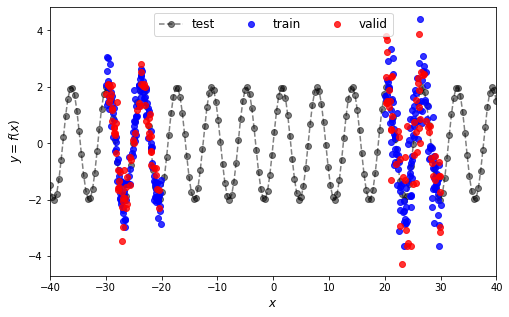

In [6]:
width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(tx.reshape(-1), ty.reshape(-1), "ko--", label="test", alpha=0.5)
plt.plot(x.reshape(-1), y.reshape(-1), "bo", label="train", alpha=0.8)
plt.plot(vx.reshape(-1), vy.reshape(-1), "ro", label="valid", alpha=0.8)

plt.ylabel("$y = f(x)$", fontsize=12)
plt.xlabel("$x$", fontsize=12)

plt.xlim(-40, 40)
plt.legend(loc="upper center", ncol=3, fontsize=12)

plt.show()

## Scaling the Data <a class="anchor" id="scaling-the-data"></a>

It is important to apply standard scaling on the input/output data to have faster convergence when training.

In [7]:
from sklearn.preprocessing import StandardScaler


scaler_x = StandardScaler()
s_x = scaler_x.fit_transform(x)
s_vx = scaler_x.transform(vx)
s_tx = scaler_x.transform(tx)

scaler_y = StandardScaler()
s_y = scaler_y.fit_transform(y)
s_vy = scaler_y.transform(vy)
s_ty = scaler_y.transform(ty)

## Baseline Neural Network <a class="anchor" id="baseline-neural-network"></a>

Let us define a baseline neural network based on a regular multi-layer perceptron architecture which learn the mean estimate and minimise the mean squared error.

In [8]:
input_ = tf.keras.layers.Input(shape=(1,))
out = tf.keras.layers.Dense(200, activation="relu")(input_)
out = tf.keras.layers.Dense(200, activation="relu")(out)
output = tf.keras.layers.Dense(1)(out)
model = tf.keras.Model(input_, output)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer, "mse")

history = model.fit(s_x, s_y, epochs=200, batch_size=4, validation_data=(s_vx, s_vy), verbose=1).history

Epoch 1/200
67/67 [==============================] - 0s 1ms/step - loss: 1.0236 - val_loss: 1.0760
Epoch 2/200
 1/67 [..............................] - ETA: 0s - loss: 0.5231

2022-06-08 11:32:19.147082: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-08 11:32:19.147251: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


67/67 [==============================] - 0s 569us/step - loss: 1.0234 - val_loss: 1.0809
Epoch 3/200
67/67 [==============================] - 0s 581us/step - loss: 1.0123 - val_loss: 1.0993
Epoch 4/200
67/67 [==============================] - 0s 551us/step - loss: 1.0025 - val_loss: 1.0697
Epoch 5/200
67/67 [==============================] - 0s 541us/step - loss: 1.0025 - val_loss: 1.0757
Epoch 6/200
67/67 [==============================] - 0s 564us/step - loss: 1.0160 - val_loss: 1.0844
Epoch 7/200
67/67 [==============================] - 0s 593us/step - loss: 0.9963 - val_loss: 1.0721
Epoch 8/200
67/67 [==============================] - 0s 559us/step - loss: 1.0087 - val_loss: 1.0737
Epoch 9/200
67/67 [==============================] - 0s 558us/step - loss: 1.0019 - val_loss: 1.0692
Epoch 10/200
67/67 [==============================] - 0s 543us/step - loss: 1.0014 - val_loss: 1.0666
Epoch 11/200
67/67 [==============================] - 0s 549us/step - loss: 1.0009 - val_loss: 1.0716


We can do a vizualisation of our learning curves to make sure the training and validation loss decrease correctly.

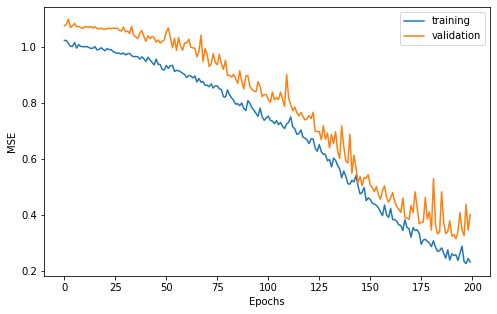

In [9]:
width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(history["loss"], label="training")
plt.plot(history["val_loss"], label="validation")

plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.legend()

plt.show()

Also, let us look at the prediction on the test set after reversing the scaling of predicted variables.

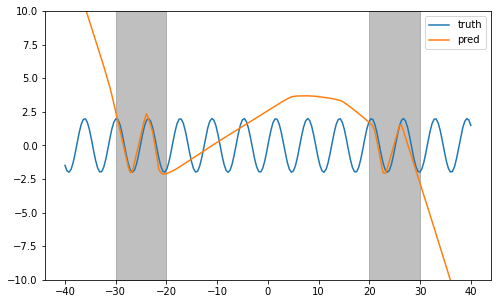

In [10]:
pred_s_ty = model(s_tx)
pred_ty = scaler_y.inverse_transform(pred_s_ty)

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(tx, ty, label="truth")
plt.plot(tx, pred_ty, label="pred")

y_lim = 10
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)

plt.legend()
plt.ylim(-y_lim, y_lim)

plt.show()

## Define the Neural Architecture Search Space <a class="anchor" id="define-the-neural-architecture-search-space"></a>

The neural architecture search space is composed of discrete decision variables. For each decision variable we choose among a list of possible operation to perform (e.g., fully connected, ReLU). To define this search space, it is necessary to use two classes:

* `KSearchSpace` (for Keras Search Space): represents a directed acyclic graph (DAG) in which each node represents a chosen operation. It represents the possible neural networks that can be created.
* `SpaceFactory`: is a utilitiy class used to pack the logic of a search space definition and share it with others.

Then, inside a `KSearchSpace` we will have two types of nodes:
* `VariableNode`: corresponds to discrete decision variables and are used to define a list of possible operation.
* `ConstantNode`: corresponds to fixed operation in the search space (e.g., input/outputs)

Finally, it is possible to reuse any `tf.keras.layers` to define a `KSearchSpace`. However, it is important to wrap each layer in an `operation` to perform a lazy memory allocation of tensors.

In [11]:
import collections

from deephyper.nas import KSearchSpace

# Decision variables are represented by nodes in a graph
from deephyper.nas.node import ConstantNode, VariableNode

# The "operation" creates a wrapper around Keras layers avoid allocating 
# memory each time a new layer is defined in the search space
# For Skip/Residual connections we use "Zero", "Connect" and "AddByProjecting"
from deephyper.nas.operation import operation, Zero, Connect, AddByProjecting, Identity

Dense = operation(tf.keras.layers.Dense)

# Possible activation functions
ACTIVATIONS = [
    tf.keras.activations.elu,
    tf.keras.activations.gelu,
    tf.keras.activations.hard_sigmoid,
    tf.keras.activations.linear,
    tf.keras.activations.relu,
    tf.keras.activations.selu,
    tf.keras.activations.sigmoid,
    tf.keras.activations.softplus,
    tf.keras.activations.softsign,
    tf.keras.activations.swish,
    tf.keras.activations.tanh,
]

We implement the constructor `__init__` and `build` method of the `RegressionSpace` a subclass of `KSearchSpace`. The `__init__` method interface is:

```python
def __init__(self, input_shape, output_shape, **kwargs):
    ...
```

for the `build` method the interface is:

```python
def build(self):
    ...
    return self
```

where:
* `input_shape` corresponds to a tuple or a list of tuple indicating the shapes of inputs tensors.
* `output_shape` corresponds to the same but of output_tensors.
* `**kwargs` denotes that any other key word argument can be defined by the user.

In [12]:
class RegressionSpace(KSearchSpace):
    
    def __init__(self, input_shape, output_shape, seed=None, num_layers=3):
        super().__init__(input_shape, output_shape, seed=seed)
        
        self.num_layers = 3
    
    def build(self):

        # After creating a KSearchSpace nodes corresponds to the inputs are directly accessible
        out_sub_graph = self.build_sub_graph(self.input_nodes[0], self.num_layers)

        output = ConstantNode(op=Dense(self.output_shape[0]))  
        self.connect(out_sub_graph, output)

        return self

    def build_sub_graph(self, input_node, num_layers=3):
        

        # Look over skip connections within a range of the 3 previous nodes
        anchor_points = collections.deque([input_node], maxlen=3)
        
        prev_node = input_node
        
        for _ in range(num_layers):
            
            # Create a variable node to list possible "Dense" layers
            dense = VariableNode()
            
            # Add the possible operations to the dense node
            self.add_dense_to_(dense)
            
            # Connect the previous node to the dense node
            self.connect(prev_node, dense)

            # Create a constant node to merge all input connections
            merge = ConstantNode()
            merge.set_op(
                AddByProjecting(self, [dense], activation="relu")
            )

            for node in anchor_points:
                
                # Create a variable node for each possible connection
                skipco = VariableNode()
                
                skipco.add_op(Zero()) # corresponds to no connection
                skipco.add_op(Connect(self, node)) # corresponds to (node => skipco)
                
                # Connect the (skipco => merge)
                self.connect(skipco, merge)

 
            # ! for next iter
            prev_node = merge
            anchor_points.append(prev_node)

        return prev_node

    def add_dense_to_(self, node):
        
        # We add the "Identity" operation to allow the choice "doing nothing"
        node.add_op(Identity())
        
        step = 16
        for units in range(step, step * 16 + 1, step):
            for activation in ACTIVATIONS:
                node.add_op(Dense(units=units, activation=activation))


Let us visualize a few randomly sampled neural architecture from this search space.

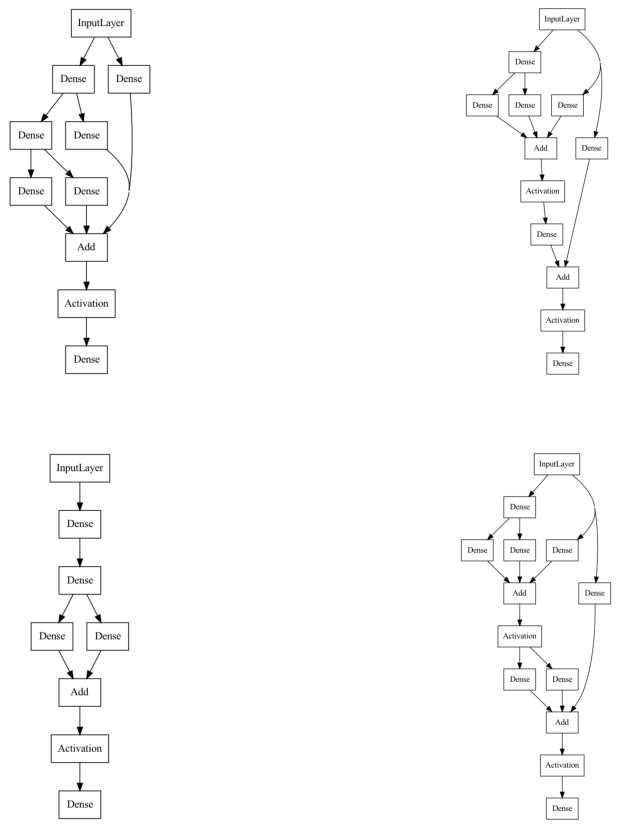

In [13]:
import matplotlib.image as mpimg
from tensorflow.keras.utils import plot_model

shapes = dict(input_shape=(1,), output_shape=(1,))
space = RegressionSpace(**shapes).build()
    

images = []
plt.figure(figsize=(15,15))
for i in range(4):
    
    model = space.sample()
    plt.subplot(2,2,i+1)
    plot_model(model, "random_model.png", show_shapes=False, show_layer_names=False)
    image = mpimg.imread("random_model.png")
    plt.imshow(image)
    plt.axis('off')

plt.show()

## Define the Neural Architecture Optimization Problem <a class="anchor" id="define-the-neural-architecture-search-optimization-problem"></a>

In order to define a neural architecture search problem we have to use the `NaProblem` class. This class gives access to different method for the user to customize the training settings of neural networks.

In [14]:
from deephyper.problem import NaProblem


def stdscaler():
    return StandardScaler()


problem = NaProblem()

# Bind a function which returns (train_input, train_output), (valid_input, valid_output)
problem.load_data(load_data_train_valid)

# Bind a function which return a scikit-learn preprocessor (with fit, fit_transform, inv_transform...etc)
problem.preprocessing(stdscaler)

# Bind a function which returns a search space and give some arguments for the `build` method
problem.search_space(RegressionSpace, num_layers=3)

# Define a set of fixed hyperparameters for all trained neural networks
problem.hyperparameters(
    batch_size=4,
    learning_rate=1e-3,
    optimizer="adam",
    num_epochs=200,
    callbacks=dict(
        EarlyStopping=dict(monitor="val_loss", mode="min", verbose=0, patience=30)
    ),
)

# Define the loss to minimize
problem.loss("mse")

# Define complementary metrics
problem.metrics([])

# Define the maximized objective. Here we take the negative of the validation loss.
problem.objective("-val_loss")

problem

Problem is:
    - search space   : __main__.RegressionSpace
    - data loading   : __main__.load_data_train_valid
    - preprocessing  : __main__.stdscaler
    - hyperparameters: 
        * verbose: 0
        * batch_size: 4
        * learning_rate: 0.001
        * optimizer: adam
        * num_epochs: 200
        * callbacks: {'EarlyStopping': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 30}}
    - loss           : mse
    - metrics        : 
    - objective      : -val_loss

<div class="alert alert-info">
    
<b>Tip</b>
    
Adding an `EarlyStopping(...)` callback is a good idea to stop the training of your model as soon as it stops to improve.

```python
...
EarlyStopping=dict(monitor="val_loss", mode="min", verbose=0, patience=30)
...
```
    
</div>



## Define the Evaluator Object

The `Evaluator` object is responsible of defining the backend used to distribute the function evaluation in DeepHyper.

In [15]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback


def get_evaluator(run_function):
    
    # Default arguments for Ray: 1 worker and 1 worker per evaluation
    method_kwargs = {
        "num_cpus": 1, 
        "num_cpus_per_task": 1,
        "callbacks": [TqdmCallback()] # To interactively follow the finished evaluations,
    }

    # If GPU devices are detected then it will create 'n_gpus' workers
    # and use 1 worker for each evaluation
    if is_gpu_available:
        method_kwargs["num_cpus"] = n_gpus
        method_kwargs["num_gpus"] = n_gpus
        method_kwargs["num_cpus_per_task"] = 1
        method_kwargs["num_gpus_per_task"] = 1

    evaluator = Evaluator.create(
        run_function, 
        method="ray", 
        method_kwargs=method_kwargs
    )
    print(f"Created new evaluator with {evaluator.num_workers} worker{'s' if evaluator.num_workers > 1 else ''} and config: {method_kwargs}", )
    
    return evaluator

For neural architecture search a standard training pipeline is provided by the `run_base_trainer` function from the `deephyper.nas.run` module.

In [16]:
from deephyper.nas.run import run_base_trainer

## Define and Run the Neural Architecture Search

All search algorithms follow a similar interface. A `problem` and `evaluator` object has to be provided to the search then the search can be executed through the `search(max_evals, timeout)` method.

In [17]:
results = {} # used to store the results of different search algorithms
max_evals = 10 # maximum number of iteratins for all searches

In [18]:
from deephyper.search.nas import Random

random_search = Random(problem, get_evaluator(run_base_trainer), log_dir="random_search")

results["random"] = random_search.search(max_evals=max_evals)

/Users/romainegele/Documents/Argonne/deephyper/deephyper/evaluator/_evaluator.py:99: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


Created new evaluator with 4 workers and config: {'num_cpus': 1, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.TqdmCallback object at 0x3453184c0>]}


  0%|          | 0/10 [00:00<?, ?it/s]

By default, the `RegularizedEvolution` has a population size of 100 therefore, it will start optimizing only after 100 evaluations.

In [19]:
from deephyper.search.nas import RegularizedEvolution

regevo_search = RegularizedEvolution(problem, get_evaluator(run_base_trainer), log_dir="regevo_search")

results["regevo"] = regevo_search.search(max_evals=max_evals)

/Users/romainegele/Documents/Argonne/deephyper/deephyper/evaluator/_evaluator.py:99: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


Created new evaluator with 4 workers and config: {'num_cpus': 1, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.TqdmCallback object at 0x3469c0550>]}


  0%|          | 0/10 [00:00<?, ?it/s]

We can now compare the search trajectories for different algorithms.

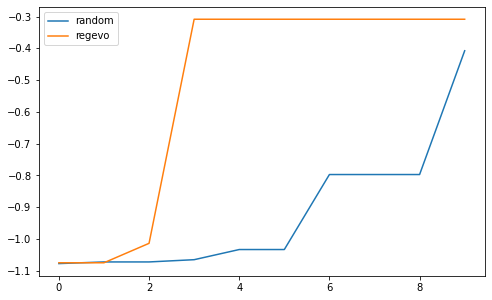

In [20]:
def max_score(l):
    r = [l[0]]
    for el in l[1:]:
        r.append(max(r[-1], el))
    return r

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

for k, result in results.items():
    plt.plot(max_score(results[k].objective), label=k)
    
plt.legend()
    
plt.show()

If we look at the dataframe of results for each search we will find it slightly different than the one of hyperparameter search. A new column `arch_seq` corresponds to an embedding for each evaluated architecture. Each integer of an `arch_seq` list corresponds to the choice of a `VariableNode` in our `KSearchSpace`.

In [21]:
results["random"]

,arch_seq,job_id,objective,timestamp_submit,timestamp_gather
0,"[46, 0, 156, 0, 0, 44, 0, 1, 0]",4,-1.077856,0.007198,4.211616
1,"[53, 0, 133, 0, 0, 52, 0, 0, 0]",3,-1.072681,0.007162,4.243041
2,"[62, 0, 112, 1, 1, 115, 1, 1, 1]",2,-1.078561,0.007126,4.252246
3,"[71, 1, 22, 1, 1, 161, 1, 0, 0]",5,-1.065605,4.234786,6.294323
4,"[107, 1, 27, 1, 0, 68, 0, 0, 0]",6,-1.033612,4.244888,8.575346
5,"[19, 1, 161, 1, 1, 132, 1, 1, 1]",7,-1.069055,4.253639,9.027878
6,"[166, 1, 19, 1, 0, 40, 0, 1, 0]",1,-0.797477,0.007086,9.302246
7,"[164, 0, 30, 0, 0, 121, 1, 1, 0]",9,-1.097940,8.577058,10.901906
8,"[17, 0, 64, 1, 0, 121, 1, 0, 1]",10,-1.134835,9.029494,13.366727
9,"[175, 1, 26, 0, 1, 29, 0, 0, 1]",8,-0.407744,6.296113,13.541472


Let us visualize the best architecture found:

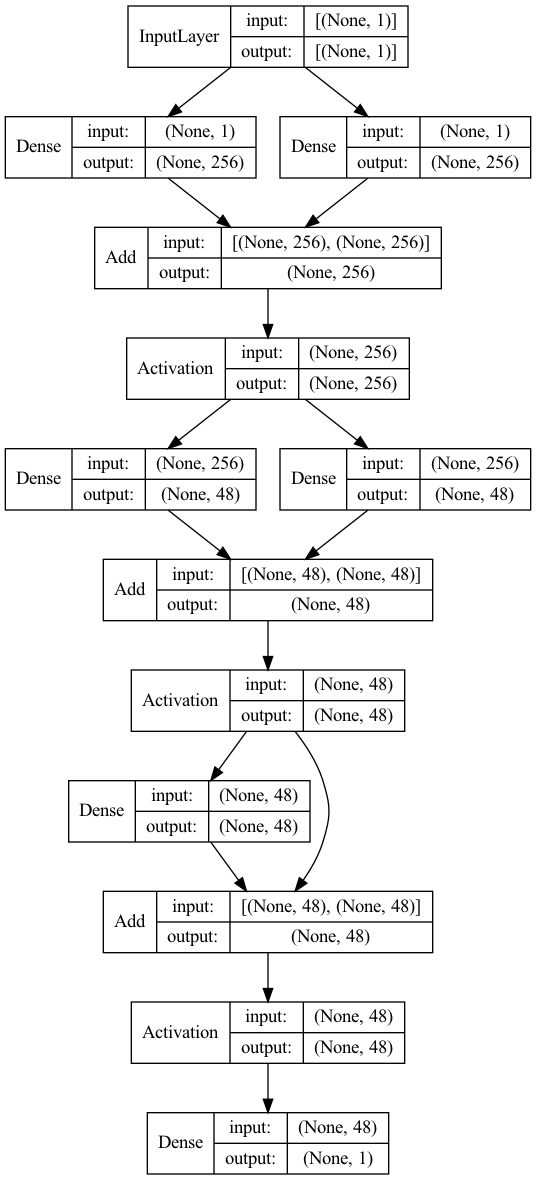

In [22]:
i_max = results["random"].objective.argmax()
best_score = results["random"].iloc[i_max].objective
best_arch_seq = json.loads(results["random"].iloc[i_max].arch_seq)

best_model = space.sample(best_arch_seq)
plot_model(best_model, show_shapes=True, show_layer_names=False)

## Adding Uncertainty Quantification to the Baseline Neural Network

To add uncertainty estimates we use the [Tensorflow Probability](https://www.tensorflow.org/probability) library which is fully compatible with the neural architecture search API because it is accessible through Keras layers.

In [23]:
import tensorflow_probability as tfp
tfd = tfp.distributions

Then, instead of minimising the mean squared error we will minimize the negative log-likelihood baed on the learned probability distribution $p(y|\mathbf{x};\theta)$ where $\theta$ represents a neural network (architecture, training hyperparameters, weights).

In [24]:
def nll(y, rv_y):
    """Negative log likelihood for Tensorflow probability.
    
    Args:
        y: true data.
        rv_y: learned (predicted) probability distribution.
    """
    return -rv_y.log_prob(y)

In [25]:
input_ = tf.keras.layers.Input(shape=(1,))
out = tf.keras.layers.Dense(200, activation="relu")(input_)
out = tf.keras.layers.Dense(200, activation="relu")(out)

# For each predicted variable (1) we need the mean and variance estimate
out = tf.keras.layers.Dense(1*2)(out) 

# We feed these estimates to output a Normal distribution for each predicted variable
output = tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(
                loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]), # positive constraint on the standard dev.
            )
        )(out)

model_uq = tf.keras.Model(input_, output)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_uq.compile(optimizer, loss=nll)

history = model_uq.fit(s_x, s_y, epochs=200, batch_size=4, validation_data=(s_vx, s_vy), verbose=1)

Epoch 1/200
 1/67 [..............................] - ETA: 8s - loss: 1.2174

2022-06-08 11:33:24.578012: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


67/67 [==============================] - 0s 1ms/step - loss: 1.6107 - val_loss: 1.6747
Epoch 2/200
67/67 [==============================] - 0s 646us/step - loss: 1.5902 - val_loss: 1.6257
Epoch 3/200
67/67 [==============================] - 0s 635us/step - loss: 1.5455 - val_loss: 1.6290
Epoch 4/200
67/67 [==============================] - 0s 624us/step - loss: 1.5151 - val_loss: 1.5265
Epoch 5/200
67/67 [==============================] - 0s 618us/step - loss: 1.4994 - val_loss: 1.4860
Epoch 6/200
67/67 [==============================] - 0s 621us/step - loss: 1.4405 - val_loss: 1.4940
Epoch 7/200
67/67 [==============================] - 0s 619us/step - loss: 1.4344 - val_loss: 1.4571
Epoch 8/200
67/67 [==============================] - 0s 607us/step - loss: 1.4260 - val_loss: 1.4532
Epoch 9/200
67/67 [==============================] - 0s 618us/step - loss: 1.4328 - val_loss: 1.4545
Epoch 10/200
67/67 [==============================] - 0s 616us/step - loss: 1.4340 - val_loss: 1.4684
Epo

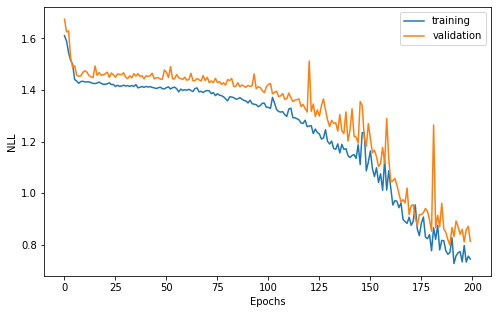

In [26]:
width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")

plt.xlabel("Epochs")
plt.ylabel("NLL")

plt.legend()

plt.show()

Let us visualize the learned uncertainty estimates.

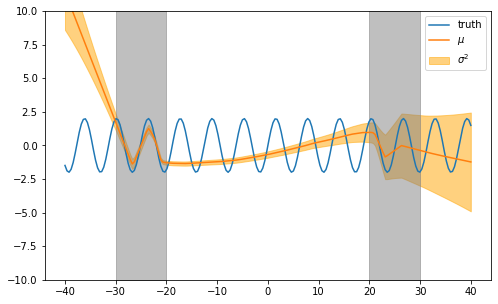

In [27]:
pred_s_ty = model_uq(s_tx)

pred_ty_mean = pred_s_ty.loc.numpy() + scaler_y.mean_
pred_ty_var = np.square(pred_s_ty.scale.numpy()) * scaler_y.var_

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(tx, ty, label="truth")
plt.plot(tx, pred_ty_mean, label="$\mu$")
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean - pred_ty_var).reshape(-1), 
    (pred_ty_mean + pred_ty_var).reshape(-1), 
    color="orange", 
    alpha=0.5,
    label="$\sigma^2$"
)

y_lim = 10
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)

plt.legend()
plt.ylim(-y_lim, y_lim)

plt.show()

The learned mean estimates appears to be worse than when minimizing the mean squared error loss. Also, we can see than the variance estimate are not meaningful in areas missing data (white background) and do not learn properly the noise in are with data (grey background).

## Ensemble of Neural Networks With Random Initialization

The uncertainty estimate of a single neural network corresponds to aleatoric uncertainty (i.e., intrinsic noise of the data). To estimate the epistemic uncertainty, composed of estimation uncertainty (e.g., optimization algorithm) and model uncertainty (e.g., hypothesis space of models), we need to quantify the variation of predictions for different models and estimation. One of the most basic method to do it is to keep a fixed neural network architecture and training hyperparameters to then re-train it multiple times from different random weight initialization.

In [28]:
def generate_model(model_id):
    
    # Model
    input_ = tf.keras.layers.Input(shape=(1,))
    out = tf.keras.layers.Dense(200, activation="relu")(input_)
    out = tf.keras.layers.Dense(200, activation="relu")(out)
    out = tf.keras.layers.Dense(2)(out) # 1 unit for the mean, 1 unit for the scale
    output = tfp.layers.DistributionLambda(
                lambda t: tfd.Normal(
                    loc=t[..., :1],
                    scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]),
                )
            )(out)
    model_uq = tf.keras.Model(input_, output)
    
    
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models_random_init", f"{model_id}.h5"), 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True,
        save_weights_only=False, 
        mode='min', 
        save_freq='epoch'
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model_uq.compile(optimizer, loss=nll)

    history = model_uq.fit(s_x, s_y, 
                           epochs=200, 
                           batch_size=4, 
                           validation_data=(s_vx, s_vy), 
                           verbose=0,
                           callbacks=[model_checkpoint_callback]
                          ).history
    return history["val_loss"][-1]

if is_gpu_available:
    generate_model = ray.remote(num_cpus=1, num_gpus=1)(generate_model)
else:
    generate_model = ray.remote(num_cpus=1)(generate_model)

We generate `n_models` from different random weight initializations. The computation can be distributed on different GPUs or CPU cores if we use Ray `.remote(...)` calls.

In [29]:
if os.path.exists("models_random_init"):
    shutil.rmtree("models_random_init")
pathlib.Path("models_random_init").mkdir(parents=False, exist_ok=False)

n_models = 10
scores = ray.get([generate_model.remote(model_id) for model_id in range(n_models)])

print(scores)

[0.8323661088943481, 0.8295519351959229, 0.8706690073013306, 0.8323661088943481, 1.1852768659591675, 0.8579176068305969, 0.8418543338775635, 0.8579176068305969, 0.8103919625282288, 0.8532550930976868]


The `UQBaggingEnsembleRegressor` provides different strategies to build ensemble of neural networks from a library of saved models. The computation is distributed with Ray (for the inference and ranking of ensemble members).

In [30]:
from deephyper.ensemble import UQBaggingEnsembleRegressor

ensemble = UQBaggingEnsembleRegressor(
    model_dir="models_random_init",
    loss=nll,  # default is nll
    size=5,
    verbose=True,
    ray_address="auto",
    num_cpus=1,
    num_gpus=1 if is_gpu_available else None,
    selection="topk",
)

In [31]:
# Follow the Scikit-Learn fit/predict interface
ensemble.fit(s_vx, s_vy)

print(f"Selected members are: ", ensemble.members_files)

Selected members are:  ['1.h5', '8.h5', '9.h5', '3.h5', '0.h5']


We can visualize the uncertainty estimate of such ensemble.

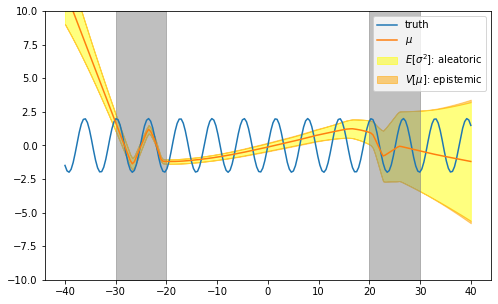

In [32]:
pred_s_ty, pred_s_ty_aleatoric_var, pred_s_ty_epistemic_var = ensemble.predict_var_decomposition(s_tx)

pred_ty_mean = pred_s_ty.loc.numpy() + scaler_y.mean_
pred_ty_aleatoric_var = pred_s_ty_aleatoric_var * scaler_y.var_
pred_ty_epistemic_var = pred_s_ty_epistemic_var * scaler_y.var_

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(tx, ty, label="truth")
plt.plot(tx, pred_ty_mean, label="$\mu$")
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var).reshape(-1), 
    color="yellow", 
    alpha=0.5,
    label="$E[\sigma^2]$: aleatoric"
)
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var - pred_s_ty_epistemic_var).reshape(-1), 
    color="orange", 
    alpha=0.5,
    label="$V[\mu]$: epistemic"
)
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var + pred_s_ty_epistemic_var).reshape(-1), 
    color="orange", 
    alpha=0.5,
#     label="$V[\mu]$: epistemic"
)

y_lim = 10
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)

plt.legend()
plt.ylim(-y_lim, y_lim)

plt.show()

By using the **Law of Total Variance** we can decompose the aleatoric and epistemic components of the predicted uncertainty. With random-initialization we can see that epistemic uncertainty is almost null everywhere and not informative on area missing data (white background).

## AutoDEUQ: Automated Deep Ensemble with Uncertainty Quantification

AutoDEUQ is an algorithm in 2 steps:
1. joint hyperparameter and neural architecture search to generate a catalog of models.
2. build an ensemble from the catalog

To this end we start by editing slightly the previous `RegressionFactory` by adding the `DistributionLambda` layer as output.

In [33]:
DistributionLambda = operation(tfp.layers.DistributionLambda)

In [34]:
class RegressionUQSpace(KSearchSpace):
    
    def __init__(self, input_shape, output_shape, seed=None, num_layers=3):
        super().__init__(input_shape, output_shape, seed=seed)
        
        self.num_layers = 3
    
    def build(self):

        out_sub_graph = self.build_sub_graph(self.input_nodes[0], self.num_layers)
        
        output_dim = self.output_shape[0]
        output_dense = ConstantNode(op=Dense(output_dim*2))  
        self.connect(out_sub_graph, output_dense)
        
        
        output_dist = ConstantNode(
            op=DistributionLambda(
                lambda t: tfd.Normal(
                    loc=t[..., :output_dim],
                    scale=1e-3 + tf.math.softplus(0.05 * t[..., output_dim:]),
                )
            )
        )
        self.connect(output_dense, output_dist)

        return self

    def build_sub_graph(self, input_node, num_layers=3):
        

        # Look over skip connections within a range of the 3 previous nodes
        anchor_points = collections.deque([input_node], maxlen=3)
        
        prev_node = input_node
        
        for _ in range(num_layers):
            
            # Create a variable node to list possible "Dense" layers
            dense = VariableNode()
            
            # Add the possible operations to the dense node
            self.add_dense_to_(dense)
            
            # Connect the previous node to the dense node
            self.connect(prev_node, dense)

            # Create a constant node to merge all input connections
            merge = ConstantNode()
            merge.set_op(
                AddByProjecting(self, [dense], activation="relu")
            )

            for node in anchor_points:
                
                # Create a variable node for each possible connection
                skipco = VariableNode()
                
                skipco.add_op(Zero()) # corresponds to no connection
                skipco.add_op(Connect(self, node)) # corresponds to (node => skipco)
                
                # Connect the (skipco => merge)
                self.connect(skipco, merge)

 
            # ! for next iter
            prev_node = merge
            anchor_points.append(prev_node)

        return prev_node

    def add_dense_to_(self, node):
        
        # We add the "Identity" operation to allow the choice "doing nothing"
        node.add_op(Identity())
        
        step = 16
        for units in range(step, step * 16 + 1, step):
            for activation in ACTIVATIONS:
                node.add_op(Dense(units=units, activation=activation))

For joint hyperparameter and neural architecture search it is possible to use the `problem.add_hyperparameter(...)` to define variable hyperparameters in the NAS Problem.

In [35]:
problem_uq = NaProblem()

problem_uq.load_data(load_data_train_valid)

problem_uq.preprocessing(stdscaler)

problem_uq.search_space(RegressionUQSpace, num_layers=3)

problem_uq.hyperparameters(
    batch_size=problem_uq.add_hyperparameter((1, 32), "batch_size"),
    learning_rate=problem_uq.add_hyperparameter(
        (1e-4, 0.1, "log-uniform"),
        "learning_rate",
    ),
    optimizer=problem_uq.add_hyperparameter(
        ["sgd", "rmsprop", "adagrad", "adam", "adadelta", "adamax", "nadam"],
        "optimizer",
    ),
    patience_ReduceLROnPlateau=problem_uq.add_hyperparameter(
        (10, 20), "patience_ReduceLROnPlateau"
    ),
    patience_EarlyStopping=problem_uq.add_hyperparameter(
        (20, 30), "patience_EarlyStopping"
    ),
    num_epochs=200,
    callbacks=dict(
        ReduceLROnPlateau=dict(monitor="val_loss", mode="min", verbose=0, patience=5),
        EarlyStopping=dict(monitor="val_loss", mode="min", verbose=0, patience=10),
        # We save trained models in neural architecture search
        ModelCheckpoint=dict(
            monitor="val_loss",
            mode="min",
            save_best_only=True,
            verbose=0,
            filepath="model.h5",
            save_weights_only=False,
        ),
    ),
)

problem_uq.loss(nll)

problem_uq.metrics([])

# The objective is maximized so we take the negative of the validation loss
# where the loss is minimized
problem_uq.objective("-val_loss")

problem_uq

Problem is:
    - search space   : __main__.RegressionUQSpace
    - data loading   : __main__.load_data_train_valid
    - preprocessing  : __main__.stdscaler
    - hyperparameters: 
        * verbose: 0
        * batch_size: batch_size, Type: UniformInteger, Range: [1, 32], Default: 16
        * learning_rate: learning_rate, Type: UniformFloat, Range: [0.0001, 0.1], Default: 0.0031622777, on log-scale
        * optimizer: optimizer, Type: Categorical, Choices: {sgd, rmsprop, adagrad, adam, adadelta, adamax, nadam}, Default: sgd
        * patience_ReduceLROnPlateau: patience_ReduceLROnPlateau, Type: UniformInteger, Range: [10, 20], Default: 15
        * patience_EarlyStopping: patience_EarlyStopping, Type: UniformInteger, Range: [20, 30], Default: 25
        * num_epochs: 200
        * callbacks: {'ReduceLROnPlateau': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 5}, 'EarlyStopping': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 10}, 'ModelCheckpoin

In [36]:
results_uq = {}

The `max_evals` has to be superior or equal to 400 to start having a good UQ estimate.

In [37]:
from deephyper.search.nas import AgEBO


if os.path.exists("agebo_search"):
    shutil.rmtree("agebo_search")

# "n_jobs" is the number of processes used to refresh the state of the surrogate model used in AgEBO 
agebo_search = AgEBO(problem_uq, get_evaluator(run_base_trainer), log_dir="agebo_search", n_jobs=4)

results_uq["agebo"] = agebo_search.search(max_evals=500)

/Users/romainegele/Documents/Argonne/deephyper/deephyper/evaluator/_evaluator.py:99: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


Created new evaluator with 4 workers and config: {'num_cpus': 1, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.TqdmCallback object at 0x34491aa60>]}


  0%|          | 0/500 [00:00<?, ?it/s]

In [38]:
results_uq["agebo"]

,arch_seq,batch_size,learning_rate,optimizer,patience_EarlyStopping,patience_ReduceLROnPlateau,job_id,objective,timestamp_submit,timestamp_gather
0,"[152, 1, 30, 0, 1, 113, 1, 1, 0]",27,0.007159,adagrad,29,12,2,-1.450841,0.173591,2.475589
1,"[66, 1, 135, 0, 1, 139, 0, 1, 0]",25,0.000148,nadam,28,15,3,-1.450301,0.173627,3.500935
2,"[56, 1, 37, 1, 1, 171, 0, 1, 1]",18,0.002885,rmsprop,28,19,4,-0.738564,0.173662,4.921706
3,"[43, 1, 116, 1, 0, 170, 1, 1, 0]",13,0.000106,rmsprop,25,18,5,-1.450331,2.657677,6.268550
4,"[118, 0, 17, 0, 0, 103, 0, 1, 0]",32,0.000166,adam,22,13,7,-1.455081,5.091059,6.817152
...,...,...,...,...,...,...,...,...,...,...
495,"[26, 1, 162, 0, 0, 52, 1, 0, 1]",5,0.003116,rmsprop,20,18,496,-1.205748,932.602933,942.308652
496,"[60, 0, 162, 0, 0, 136, 1, 0, 0]",6,0.003067,rmsprop,23,16,500,-0.660088,943.115550,951.733516
497,"[60, 0, 162, 0, 1, 136, 1, 0, 1]",5,0.003600,rmsprop,22,17,498,-0.703299,938.832237,952.509710
498,"[26, 1, 162, 0, 0, 136, 1, 0, 0]",1,0.002147,rmsprop,20,10,499,-1.411145,939.592606,952.510410


Different sizes of ensemble and two selection strategies can be experimented for ensembles:
* `caruana`: a greedy selection from Caruana based on the loss function.
* `topk`: select the top-k (i.e., `size`) best models based on the loss function.

In [39]:
ensemble = UQBaggingEnsembleRegressor(
    model_dir="agebo_search/save/model",
    loss=nll,  # default is nll
    size=5,
    verbose=True,
    ray_address="auto",
    num_cpus=1,
    num_gpus=1 if is_gpu_available else None,
    selection="caruana",
)

ensemble.fit(s_vx, s_vy)

print(f"Selected {len(ensemble.members_files)} members are: ", ensemble.members_files)

Selected 5 members are:  ['dc560236-e70f-11ec-a314-5e52ffa7b52c.h5', '2f251484-e710-11ec-a314-5e52ffa7b52c.h5', '2c4ed40c-e710-11ec-8e5f-5e52ffa7b52c.h5', 'fae39bdc-e70f-11ec-8e5f-5e52ffa7b52c.h5', 'd939d54c-e70e-11ec-a3ef-5e52ffa7b52c.h5']


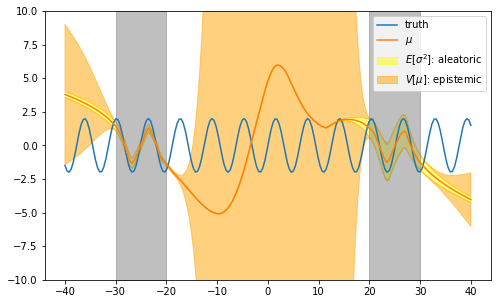

In [40]:
pred_s_ty, pred_s_ty_aleatoric_var, pred_s_ty_epistemic_var = ensemble.predict_var_decomposition(s_tx)

pred_ty_mean = pred_s_ty.loc.numpy() + scaler_y.mean_
pred_ty_aleatoric_var = pred_s_ty_aleatoric_var * scaler_y.var_
pred_ty_epistemic_var = pred_s_ty_epistemic_var * scaler_y.var_

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(tx, ty, label="truth")
plt.plot(tx, pred_ty_mean, label="$\mu$")
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var).reshape(-1), 
    color="yellow", 
    alpha=0.5,
    label="$E[\sigma^2]$: aleatoric"
)
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var - pred_ty_epistemic_var).reshape(-1), 
    color="orange", 
    alpha=0.5,
    label="$V[\mu]$: epistemic"
)
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var + pred_ty_epistemic_var).reshape(-1), 
    color="orange", 
    alpha=0.5,
)

y_lim = 10
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)

plt.legend()
plt.ylim(-y_lim, y_lim)

plt.show()

We notice that adding more diversity in the catalog can help have much better epistemic uncertainty estimates.

## Random Forest

What if we compare this to using the same technic (i.e., law of total variance) on the trees used to build a random forest regressor.

In [45]:
import warnings

from deephyper.skopt.learning import RandomForestRegressor

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    rf_model = RandomForestRegressor()

    rf_model.fit(s_x, s_y)

In [46]:
pred_s_ty, pred_s_ty_std = rf_model.predict(s_tx, return_std=True)
pred_s_ty_var = pred_s_ty_std ** 2

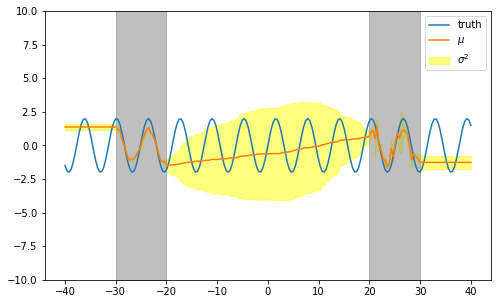

In [47]:
pred_ty_mean = pred_s_ty + scaler_y.mean_
pred_ty_var = pred_s_ty_var * scaler_y.var_

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(tx, ty, label="truth")
plt.plot(tx, pred_ty_mean, label="$\mu$")
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean - pred_ty_var).reshape(-1), 
    (pred_ty_mean + pred_ty_var).reshape(-1), 
    color="yellow", 
    alpha=0.5,
    label="$\sigma^2$"
)

y_lim = 10
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)

plt.legend()
plt.ylim(-y_lim, y_lim)

plt.show()

We can see that the uncertainty estimate is really poor in this case.